# Logistic Regression with L2 Regularization

In this notebook we will implement a logistic regression classifier with L2 regularization. We will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [5]:
from __future__ import division
import turicreate
import numpy as np
import os
import math

## Load in Dataset

For this assignment, we will use a dataset consisting of Amazon product reviews.

In [16]:
products=turicreate.SFrame(r'amazon_baby_subset.csv')

Finished parsing file /home/ian/venv/UWashington_MachineLearningSpecialization/Notebooks/GitHub/GitHub Data/Edited/amazon_baby_subset.csv

Parsing completed. Parsed 100 lines in 0.163708 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/ian/venv/UWashington_MachineLearningSpecialization/Notebooks/GitHub/GitHub Data/Edited/amazon_baby_subset.csv

Parsing completed. Parsed 49999 lines in 0.216536 secs.

We will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)


In [18]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

import string 
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

Now, let us take a look at what the dataset looks like.

In [19]:
products.head()

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5,1,It has been many yearssince we needed diaper ...,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. 

In [20]:
train_data, validation_data = products.random_split(.8, seed=2)

print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 39864 data points
Validation set : 10135 data points


## Convert SFrame to NumPy array

Similar to our other notebooks, we write a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [21]:
def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [22]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

## Logistic Regression with No L2 Penalty 

The link function for logistic regression can be defined as:

$$
P(y_i = 1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. We write a function to calculate this probability:

In [23]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    scores=np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1./(1 + np.exp(-scores))
    
    return predictions

# Add  L2 Penalty

We now implement logistic regression with L2 regularization.

Recall that that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* The link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [24]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and features
    derivative = np.dot(errors,feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative -= (2 * l2_penalty * coefficient)
        
    return derivative

To verify the correctness of the gradient ascent algorithm, we write a function for computing log likelihood.

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [25]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

We now write the function to implement logistic regression with L2 regularization:

In [28]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j], coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [29]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=0, max_iter=100)

iteration  0: log likelihood of observed labels = -27459.07277126
iteration  1: log likelihood of observed labels = -27294.77158347
iteration  2: log likelihood of observed labels = -27137.43448924
iteration  3: log likelihood of observed labels = -26986.19369317
iteration  4: log likelihood of observed labels = -26840.43853928
iteration  5: log likelihood of observed labels = -26699.71899389
iteration  6: log likelihood of observed labels = -26563.68648085
iteration  7: log likelihood of observed labels = -26432.05770272
iteration  8: log likelihood of observed labels = -26304.59250406
iteration  9: log likelihood of observed labels = -26181.08028614
iteration 10: log likelihood of observed labels = -26061.33161999
iteration 11: log likelihood of observed labels = -25945.17301568
iteration 12: log likelihood of observed labels = -25832.44360678
iteration 13: log likelihood of observed labels = -25722.99299736
iteration 14: log likelihood of observed labels = -25616.67981609
iteration 

In [31]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=100)

iteration  0: log likelihood of observed labels = -27459.07609458
iteration  1: log likelihood of observed labels = -27294.79095052
iteration  2: log likelihood of observed labels = -27137.48163097
iteration  3: log likelihood of observed labels = -26986.27952317
iteration  4: log likelihood of observed labels = -26840.57325544
iteration  5: log likelihood of observed labels = -26699.91214431
iteration  6: log likelihood of observed labels = -26563.94701209
iteration  7: log likelihood of observed labels = -26432.39399947
iteration  8: log likelihood of observed labels = -26305.01242455
iteration  9: log likelihood of observed labels = -26181.59119510
iteration 10: log likelihood of observed labels = -26061.94041987
iteration 11: log likelihood of observed labels = -25945.88617638
iteration 12: log likelihood of observed labels = -25833.26719380
iteration 13: log likelihood of observed labels = -25723.93269840
iteration 14: log likelihood of observed labels = -25617.74096611
iteration 

In [32]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=100)

iteration  0: log likelihood of observed labels = -27459.08107955
iteration  1: log likelihood of observed labels = -27294.81999913
iteration  2: log likelihood of observed labels = -27137.55233404
iteration  3: log likelihood of observed labels = -26986.40824225
iteration  4: log likelihood of observed labels = -26840.77527563
iteration  5: log likelihood of observed labels = -26700.20177334
iteration  6: log likelihood of observed labels = -26564.33765300
iteration  7: log likelihood of observed labels = -26432.89821036
iteration  8: log likelihood of observed labels = -26305.64197188
iteration  9: log likelihood of observed labels = -26182.35710331
iteration 10: log likelihood of observed labels = -26062.85301843
iteration 11: log likelihood of observed labels = -25946.95514446
iteration 12: log likelihood of observed labels = -25834.50160274
iteration 13: log likelihood of observed labels = -25725.34105169
iteration 14: log likelihood of observed labels = -25619.33123705
iteration 

In [33]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=100)

iteration  0: log likelihood of observed labels = -27459.15585420
iteration  1: log likelihood of observed labels = -27295.25544577
iteration  2: log likelihood of observed labels = -27138.61151071
iteration  3: log likelihood of observed labels = -26988.33530265
iteration  4: log likelihood of observed labels = -26843.79780823
iteration  5: log likelihood of observed labels = -26704.53232935
iteration  6: log likelihood of observed labels = -26570.17487316
iteration  7: log likelihood of observed labels = -26440.42775519
iteration  8: log likelihood of observed labels = -26315.03735209
iteration  9: log likelihood of observed labels = -26193.78045247
iteration 10: log likelihood of observed labels = -26076.45582385
iteration 11: log likelihood of observed labels = -25962.87894086
iteration 12: log likelihood of observed labels = -25852.87862904
iteration 13: log likelihood of observed labels = -25746.29487022
iteration 14: log likelihood of observed labels = -25642.97731473
iteration 

In [34]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=100)

iteration  0: log likelihood of observed labels = -27459.90360072
iteration  1: log likelihood of observed labels = -27299.58085817
iteration  2: log likelihood of observed labels = -27149.06312169
iteration  3: log likelihood of observed labels = -27007.22647164
iteration  4: log likelihood of observed labels = -26873.23576613
iteration  5: log likelihood of observed labels = -26746.43839519
iteration  6: log likelihood of observed labels = -26626.30014608
iteration  7: log likelihood of observed labels = -26512.36641090
iteration  8: log likelihood of observed labels = -26404.23854940
iteration  9: log likelihood of observed labels = -26301.55929804
iteration 10: log likelihood of observed labels = -26204.00358151
iteration 11: log likelihood of observed labels = -26111.27255924
iteration 12: log likelihood of observed labels = -26023.08961916
iteration 13: log likelihood of observed labels = -25939.19755448
iteration 14: log likelihood of observed labels = -25859.35646999
iteration 

In [35]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=100)

iteration  0: log likelihood of observed labels = -27542.15571751
iteration  1: log likelihood of observed labels = -27535.04014166
iteration  2: log likelihood of observed labels = -27528.63578186
iteration  3: log likelihood of observed labels = -27522.80554197
iteration  4: log likelihood of observed labels = -27517.49619320
iteration  5: log likelihood of observed labels = -27512.66110182
iteration  6: log likelihood of observed labels = -27508.25787224
iteration  7: log likelihood of observed labels = -27504.24790155
iteration  8: log likelihood of observed labels = -27500.59603841
iteration  9: log likelihood of observed labels = -27497.27027477
iteration 10: log likelihood of observed labels = -27494.24146503
iteration 11: log likelihood of observed labels = -27491.48307021
iteration 12: log likelihood of observed labels = -27488.97092489
iteration 13: log likelihood of observed labels = -27486.68302497
iteration 14: log likelihood of observed labels = -27484.59933427
iteration 

## Compare Coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [36]:
table = turicreate.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [38]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
(intercept),0.12077538629,0.120837177632,0.120929677507,0.122290363704
baby,0.0806684834449,0.0805531702888,0.0803807745776,0.0778750649925
one,-0.0155791280791,-0.0155811061444,-0.0155840572695,-0.0156259895979
great,0.476060832062,0.475250510145,0.474039082779,0.456436057403
love,0.522679225573,0.521754867199,0.520372989047,0.500298084494
use,0.0271675964657,0.0271267294115,0.0270656466401,0.0261797432593
would,-0.249853453521,-0.249504687792,-0.248983294022,-0.241407805095
like,0.00396184213795,0.00394894783287,0.00392967149579,0.00364962917497
easy,0.497901851042,0.497031255893,0.495729740545,0.476820669276
little,0.324335424182,0.323786752058,0.322966479417,0.311045781121


In [39]:
positive_words = table.sort('coefficients [L2=0]', ascending = False)[0:5]['word']
negative_words = table.sort('coefficients [L2=0]', ascending = True)[0:5]['word']

Let us observe the effect of increasing L2 penalty on the 10 words just selected.

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 10})
    plt.tight_layout()

We can now explore the coefficient path as the L2 penalty increases:

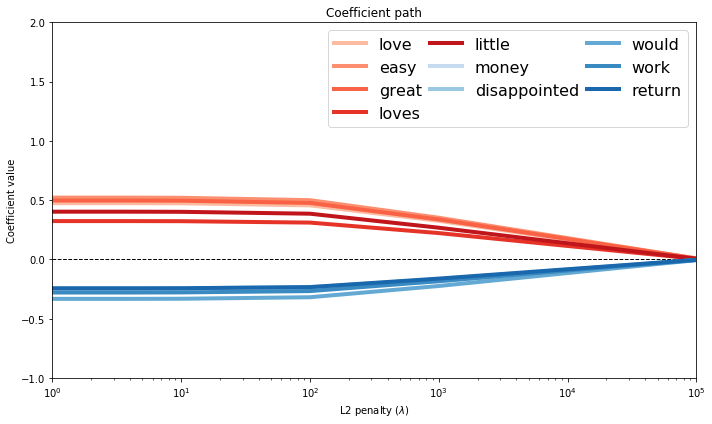

In [53]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

## Measuring Accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


and that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

In [42]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [43]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [44]:
# Build a simple report 
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.7679108970499698, validation_accuracy = 0.7615194869264924
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7679108970499698, validation_accuracy = 0.7614208189442526
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7679359823399559, validation_accuracy = 0.7611248149975333
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7671834236403773, validation_accuracy = 0.760434139121855
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.757901866345575, validation_accuracy = 0.7489886531820424
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.5332630945213727, validation_accuracy = 0.5263936852491367
----------------------------

<function matplotlib.pyplot.tight_layout>

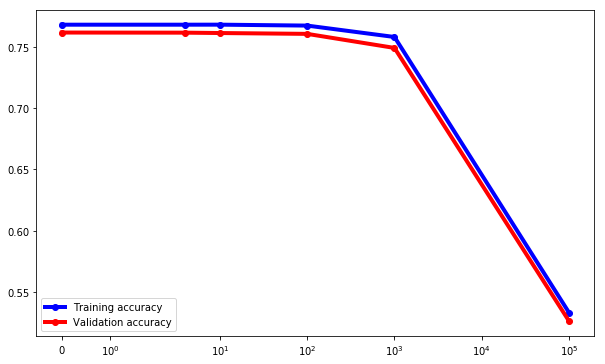

In [49]:
# Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout

As we can see, regularization has a noticeable impact on the accuracy of the model when applied to both the training and validation datasets. But in the case of the latter, there is a decidedly positive impact when the penalty equals 10.